In [1]:
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from torchvision import transforms, datasets
from torchsummary import summary

In [2]:
class FireNet(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(FireNet, self).__init__()
        c, _, _ = input_size

        # c = 32
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(c, 5*c, (7, 7)),
            torch.nn.ReLU(inplace=True),

            torch.nn.MaxPool2d((3, 3), stride=2),

            torch.nn.LocalResponseNorm(2),

            # torch.nn.Conv2d(5*c, c, (1, 1)),
            # torch.nn.ReLU(inplace=True),

            # torch.nn.BatchNorm2d(c),

            # torch.nn.Conv2d(c, 3*c, (3, 3)),
            # torch.nn.ReLU(inplace=True),

            # torch.nn.LocalResponseNorm(2),

            # torch.nn.MaxPool2d((3, 3), stride=2),

            # torch.nn.Conv2d(3*c, 3*c, (1, 1)),
            # torch.nn.ReLU(inplace=True),

            # torch.nn.Conv2d(3*c, 4*c, (1, 1)),
            # torch.nn.ReLU(inplace=True),

            # torch.nn.Conv2d(4*c, 5*c, (3, 3)),
            # torch.nn.ReLU(inplace=True),

            # torch.nn.BatchNorm2d(5*c),

            # torch.nn.Conv2d(5*c, c, (5, 5)),
            # torch.nn.ReLU(inplace=True),

            # torch.nn.MaxPool2d((3, 3), stride=1),

            # torch.nn.Conv2d(c, c, (1, 1)),
            # torch.nn.ReLU(inplace=True),

            torch.nn.AvgPool2d((5,5)),

            torch.nn.Dropout(0.4)
            
        )


        self.fc = torch.nn.Sequential(
            torch.nn.Linear(60, 120),
            torch.nn.ReLU(inplace=True),

            torch.nn.Linear(120, 84),
            torch.nn.ReLU(inplace=True),

        )

    def forward(self, x):
        x = self.layer1(x)
        # x = x.view(x.size(0), -1)
        x = x.view(-1,x.size(-3)*x.size(-2)*x.size(-1))
        x = self.fc(x)
        return x


In [3]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(640, 160)
        self.l2 = torch.nn.Linear(160, 40)
        self.l3 = torch.nn.Linear(40, 10)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.sigmoid(self.l1(x)) 
        out2 = self.sigmoid(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((640, 640), interpolation=3),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

/Users/outjack/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [6]:
# data = torch.utils.data.DataLoader('/content/drive/MyDrive/fire_datasets', transform=train_transform)
# data = datasets.ImageFolder('/content/drive/MyDrive/fire_datasets',       
#                     transform=train_transform)
data = datasets.ImageFolder('data/first_data',       
                    transform=train_transform)

train_data, val_data = torch.utils.data.random_split(data, [200, 67])

In [7]:
label2name = ['fire', 'nonfire']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

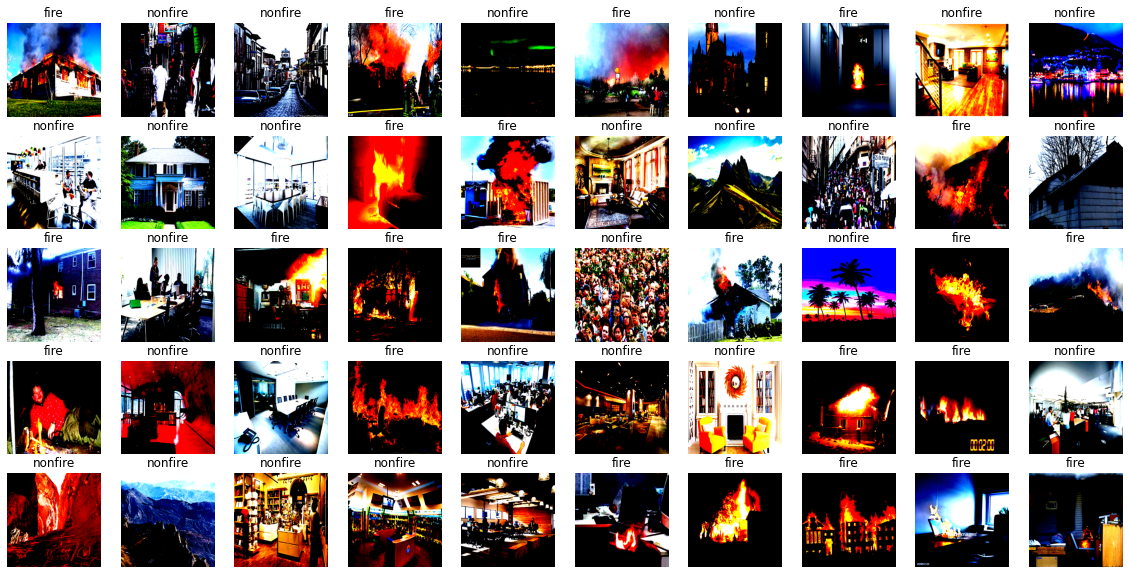

In [8]:
w, h = 10, 5
rand_idxs = np.random.choice(np.arange(len(train_data)), replace=False, size=w*h)
fig, axes = plt.subplots(ncols=w, nrows=h, figsize=(20, 10))
for idx, ax in zip(rand_idxs, axes.ravel()):
    x, y = train_data[idx]
    ax.imshow(x.permute(1, 2, 0), cmap='gray')
    ax.title.set_text(f'{label2name[y]}')
    ax.axis('off')

In [9]:
input_size = (3, 32, 32)
# model = FireNet(input_size=input_size, num_classes=2)
model = Model()
# summary(model, input_size=input_size, device='cpu')

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 1100
EPOCHS = 15
LR = 1e-4
WEIGHT_DECAY = 1e-5
device

'cpu'

In [11]:
model.to(device)

Model(
  (l1): Linear(in_features=640, out_features=160, bias=True)
  (l2): Linear(in_features=160, out_features=40, bias=True)
  (l3): Linear(in_features=40, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
# metric
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()
        
    def update(self, y_pred, y_true):
        print(len(y_pred[:len(y_true)].argmax(-1)))
        print(len(y_true))
        self.correct += torch.sum(y_pred[:len(y_true)].argmax(-1) == y_true).item()
        self.total += y_true.size(0)
        
    def compute(self):
        return self.correct / self.total
    
    def reset(self):
        self.correct = 0
        self.total = 0


In [14]:
import torch.nn.functional as F


def train(model, train_loader, optimizer, accuracy):
    """
    Training of an epoch
    model: network
    train_loader: train_loader loading images and labels in batches
    optimizer: optimizer to use in the training
    """
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # zero the accumulated gradients
        output = model(data) # computer network's output
        # loss = F.cross_entropy(output, target) # computer the loss
        # loss.backward() # backward pass
        optimizer.step() # update weights
        
        # total_loss = total_loss + loss.item()

        # accuracy.update(output, target)
        
        # if batch_idx % 100 == 0:
        #     print('[{}/{} ({:.0f}%)]\tBatch loss: {:.6f}'.format(
        #         batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()/len(data)))
    
    # print('Training: Epoch average loss {:.6f}'.format(total_loss/len(train_loader.dataset)))
    # print('Validation: Epoch accuracy {:.6f}'.format(accuracy.compute()))
    # accuracy.reset()
    

In [15]:
def test(model, val_loader, accuracy):
    """
    Compute accuracy on the validation set
    model: network
    val_loader: test_loader loading images and labels in batches
    """
    model.eval()
    
    # implement validation procedure, report accuracy on the validation set
    
    ### MY CODE HERE
    batch_valid_loss = []
    with torch.no_grad():
        for data, target in tqdm(val_loader):
            output = model(data) # computer network's output
            # accuracy.update(output, target)

    # print('Validation: Epoch accuracy {:.6f}'.format(accuracy.compute()))
    # accuracy.reset()

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4
)

valid_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=4
)

In [17]:
EPOCH = 20

train_accuracy = AccuracyMetric()
valid_accuracy = AccuracyMetric()
for epoch in range(1, EPOCH + 1):
        print('Epoch {}'.format(epoch))
        train(model, train_dataloader, optimizer, train_accuracy)
        test(model, valid_dataloader, valid_accuracy)

Epoch 1


100%|██████████| 1/1 [00:08<00:00,  8.98s/it]

Epoch 2



100%|██████████| 1/1 [00:08<00:00,  8.94s/it]

Epoch 3



100%|██████████| 1/1 [00:08<00:00,  8.98s/it]

Epoch 4



100%|██████████| 1/1 [00:08<00:00,  8.88s/it]

Epoch 5



100%|██████████| 1/1 [00:08<00:00,  8.94s/it]

Epoch 6



100%|██████████| 1/1 [00:08<00:00,  8.91s/it]

Epoch 7



100%|██████████| 1/1 [00:08<00:00,  9.00s/it]

Epoch 8



100%|██████████| 1/1 [00:08<00:00,  8.89s/it]

Epoch 9



100%|██████████| 1/1 [00:08<00:00,  8.89s/it]

Epoch 10



100%|██████████| 1/1 [00:08<00:00,  8.84s/it]

Epoch 11



100%|██████████| 1/1 [00:09<00:00,  9.01s/it]

Epoch 12



100%|██████████| 1/1 [00:08<00:00,  8.89s/it]

Epoch 13



100%|██████████| 1/1 [00:08<00:00,  8.91s/it]

Epoch 14



100%|██████████| 1/1 [00:08<00:00,  8.91s/it]

Epoch 15



100%|██████████| 1/1 [00:09<00:00,  9.37s/it]

Epoch 16



100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

Epoch 17



100%|██████████| 1/1 [00:08<00:00,  8.77s/it]

Epoch 18



100%|██████████| 1/1 [00:08<00:00,  8.75s/it]

Epoch 19



100%|██████████| 1/1 [00:08<00:00,  8.76s/it]

Epoch 20



100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Evaluation

In [18]:
model.eval()
with torch.no_grad():
    for X_batch, y_batch in tqdm(valid_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        # accuracy.update(y_pred, y_batch)
# print(f'Validation Accuracy: {accuracy.compute()}')

100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


In [19]:
X, Y_true, Y_pred = X_batch.cpu(), y_batch.cpu(), y_pred.cpu()

In [20]:
Y_true.shape

torch.Size([67])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Accuracy: 0.42


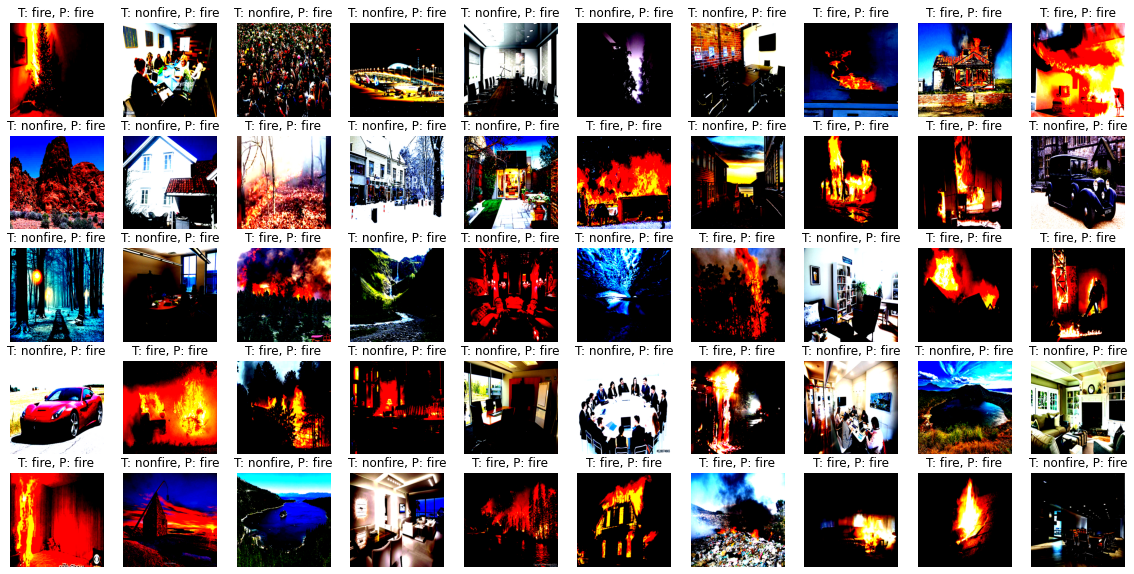

In [21]:
w, h = 10, 5
all, correct = 0, 0
rand_idxs = np.random.choice(np.arange(len(X)), replace=False, size=w*h)
fig, axes = plt.subplots(ncols=w, nrows=h, figsize=(20, 10))
for idx, ax in zip(rand_idxs, axes.ravel()):
    x, y_true, y_pred = X[idx], Y_true[idx], Y_pred[idx][0][0]
    y_pred = torch.round(torch.mean(y_pred)).int()
    if y_pred == y_true:
        correct += 1
    all += 1
    ax.imshow(x.permute(1, 2, 0))
    ax.title.set_text(f'T: {label2name[y_true]}, P: {label2name[y_pred]}')
    ax.axis('off')
print(f"Accuracy: {correct/all}")